In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

In [3]:
# data 

character = pd.read_csv("data/character.metadata.tsv", sep='\t')
movie = pd.read_csv("data/movie.metadata.tsv", sep='\t')

# Add headers to the DataFrame
movie.columns = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 
    'Movie box office revenue', 'Movie runtime', 'Movie languages (Freebase ID:name tuples)', 
    'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)'
]

# Add headers to the DataFrame
character.columns = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 
    'Actor date of birth', 'Actor gender', 'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 
    'Actor name', 'Actor age at movie release', 'Freebase character/actor map ID', 
    'Freebase character ID', 'Freebase actor ID'
]

In [4]:
# loading the data and keeping only movies in collections

new_data = pd.read_csv('data/movie_metadata_with_tmdb.csv')
data_with_coll = new_data.copy()[new_data['collection_id'].notnull()]
#print(data_with_coll.head())
#print(type(data_with_coll))
#print(collection.size)

### Basic numerical analysis

In [5]:
# Counting the number of movies per collections
collection_counts = data_with_coll.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(collection_counts.describe())
# Keeping only the movies with more than 1 movie per collection
valid_coll_id = collection_counts[collection_counts > 1].index
collections = data_with_coll[data_with_coll['collection_id'].isin(valid_coll_id)]
#collection['Wikipedia movie ID'].count().max()
#print(collections.head())
#print(collections)

count    2604.000000
mean        2.374040
std         3.132476
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64


In [6]:
# Summarizing the data

# Counting the number of movies per collection again
counts = collections.groupby(by='collection_id')['Wikipedia movie ID'].count()#.sort_values(ascending=False)
print(counts.describe())
#collection['Wikipedia movie ID'].count().max()
#len(new_data.groupby(by='collection_id')['Wikipedia movie ID'].count())
#collections.groupby(by='collection_id')['Wikipedia movie ID'].count().sort_values(ascending=False).head(1)

count    1595.000000
mean        3.243260
std         3.751337
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64


here we have an outlier : one collecion has 66 movies \
We see there is min = 2 --> ok

looking at proportion of movies in collections versus total dataset

### Basic visualization

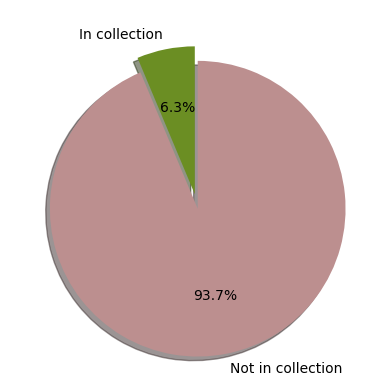

In [7]:
proportion = len(collections) / len(new_data)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In collection', 'Not in collection'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], explode=explode, labels=proportions.index, colors=['olivedrab', 'rosybrown'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

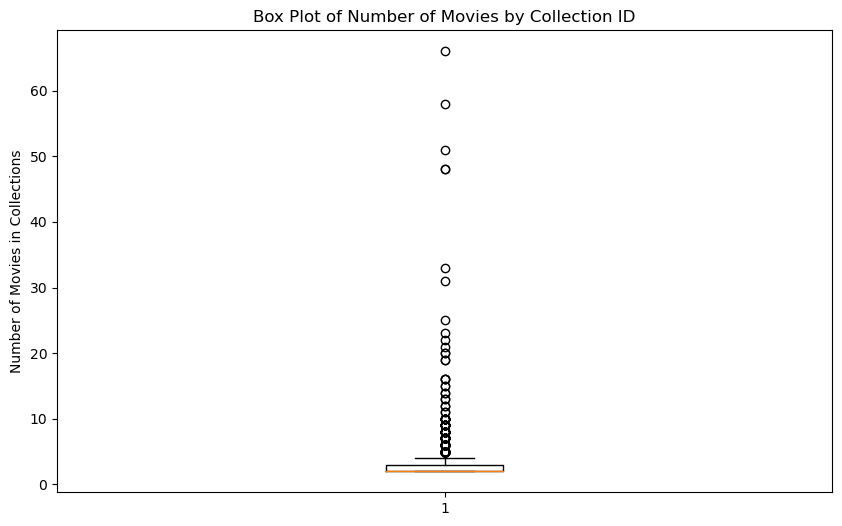

In [8]:
plt.figure(figsize=(10, 6))
plt.boxplot(counts)
plt.title('Box Plot of Number of Movies by Collection ID')
plt.ylabel('Number of Movies in Collections')
plt.show()

#look  at 75 percentile ?

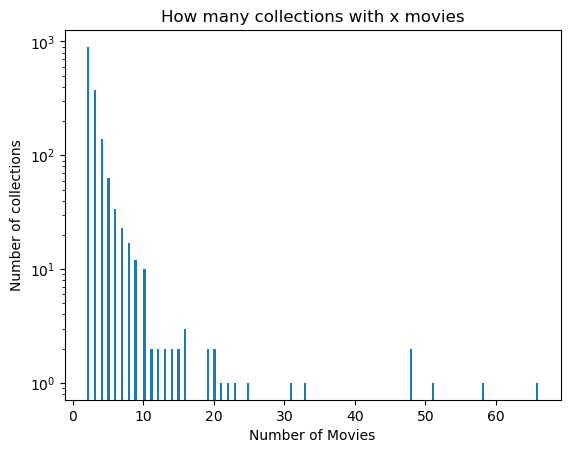

Number of unique values in counts: 27
<class 'pandas.core.series.Series'>


In [9]:
# Plotting the number of collections with x movies

#plt.hist(figsize=(15, 2))
plt.hist(counts, bins=200)
plt.yscale('log')
plt.title('How many collections with x movies')
plt.ylabel('Number of collections')
plt.xlabel('Number of Movies')
#plt.xticks(sorted(set(counts)))  
plt.show()

print(f"Number of unique values in counts: {counts.nunique()}")

print(type(counts))

<class 'pandas.core.series.Series'>


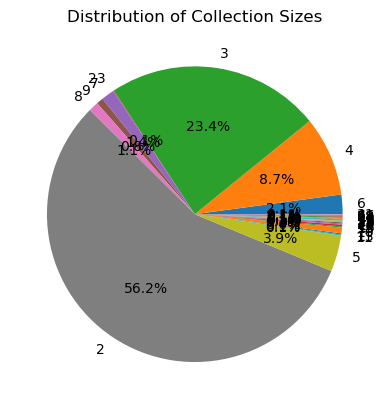

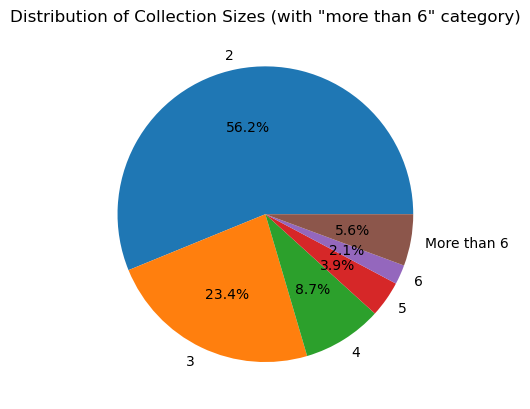

In [10]:
# plotting a pie chart of the number of movies per collection
print(type(counts))
collection_size_counts_df = pd.DataFrame.from_dict(Counter(counts), orient='index', columns=['count'])
# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(collection_size_counts_df['count'], labels=collection_size_counts_df.index, autopct='%1.1f%%')
plt.title('Distribution of Collection Sizes')
plt.show()

# Label collections with more than 6 movies
collection_size_counts_df['category'] = collection_size_counts_df.index.where(collection_size_counts_df.index <= 6, 'More than 6')

# Group by the new category and sum the counts
collection_size_counts_df = collection_size_counts_df.groupby('category')['count'].sum().reset_index()

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(collection_size_counts_df['count'], labels=collection_size_counts_df['category'], autopct='%1.1f%%')
plt.title('Distribution of Collection Sizes (with "more than 6" category)')
plt.show()

### Focusing on genres

for all genres in collections

                   genre  counts
14              "Comedy"    1065
1             "Thriller"     969
28               "Drama"     917
5     "Action/Adventure"     816
49              "Action"     778
..                   ...     ...
207   "Comedy of Errors"       1
357  "Comedy of manners"       1
356  "Outlaw biker film"       1
208          "Tollywood"       1
434     "Indian Western"       1

[435 rows x 2 columns]


Text(0.5, 1.0, 'Distribution of Genres in Collections')

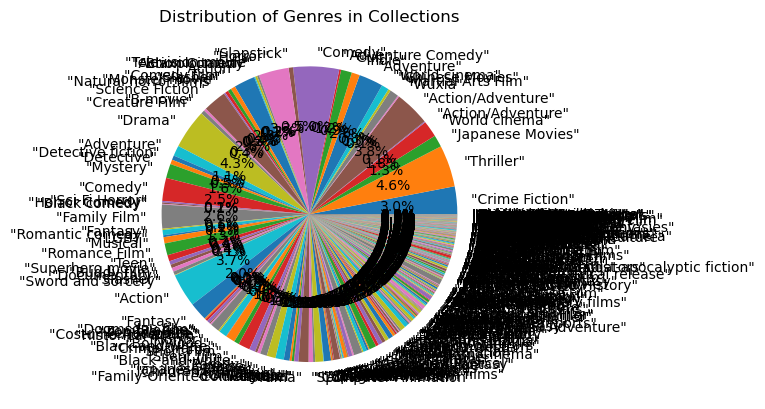

In [11]:
# Split the genres and count them
genre_counts = Counter()

for genres in collections['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip() for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','') # works
print(genre_counts_df.sort_values(by='counts', ascending=False))

#new_counts = pd.DataFrame.from_dict(genre_counts_df.groupby('genre')['counts'].sum().reset_index())

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(genre_counts_df['counts'], labels=genre_counts_df['genre'], autopct='%1.1f%%')
plt.title('Distribution of Genres in Collections')

grouping genres that appear less than 10 times

                  genre  counts
0           "Absurdism"      13
1    "Action Thrillers"     128
2              "Action"    1268
3    "Action/Adventure"     841
4               "Adult"      24
..                  ...     ...
124      "World cinema"     553
125             "Wuxia"      30
126       "Zombie Film"      52
127              Comedy    2417
128               Other     866

[129 rows x 2 columns]


,genre,counts
0,"""Absurdism""",13
1,"""Action Thrillers""",128
2,"""Action""",1268
3,"""Action/Adventure""",841
4,"""Adult""",24
...,...,...
124,"""World cinema""",553
125,"""Wuxia""",30
126,"""Zombie Film""",52
127,Comedy,2417


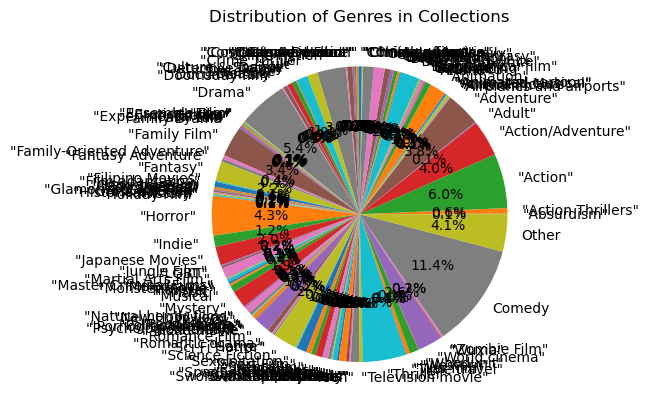

In [12]:
# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].apply(lambda x: "Comedy" if "comedy" in x.lower() else x)

# Replace any genre with less than 10 counts with "Other"

genre_counts_df['genre'] = genre_counts_df['genre'].where(genre_counts_df['counts'] > 10, 'Other')
print(genre_counts_df.groupby('genre')['counts'].sum().reset_index())
# Print the genre counts
#print(genre_counts_df.sort_values(by='counts', ascending=False))

new_counts = pd.DataFrame.from_dict(genre_counts_df.groupby('genre')['counts'].sum().reset_index())

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(new_counts['counts'], labels=new_counts['genre'], autopct='%1.1f%%')
plt.title('Distribution of Genres in Collections')
new_counts

group genres that appear less than 1%

Text(0.5, 1.0, 'Distribution of Genres in Collections')

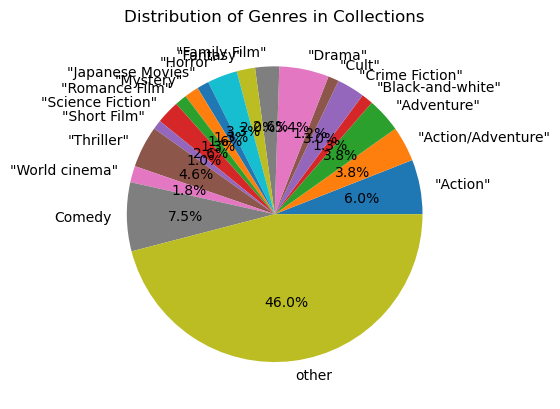

In [13]:
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','') # why do I have to do it again????
# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 1%
threshold_count = total_genres_count * 0.01
# Replace genres with counts below the threshold with "other"
genre_counts_df['genre'] = genre_counts_df.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
# Print the genre counts
#print(genre_counts_df.sort_values(by='counts', ascending=False))

new_counts = pd.DataFrame.from_dict(genre_counts_df.groupby('genre')['counts'].sum().reset_index())

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(new_counts['counts'], labels=new_counts['genre'], autopct='%1.1f%%')
plt.title('Distribution of Genres in Collections')

for all common genres

                   genre  counts
14              "Comedy"    1065
1             "Thriller"     969
28               "Drama"     917
5     "Action/Adventure"     816
49              "Action"     778
..                   ...     ...
207   "Comedy of Errors"       1
357  "Comedy of manners"       1
356  "Outlaw biker film"       1
208          "Tollywood"       1
434     "Indian Western"       1

[435 rows x 2 columns]


Text(0.5, 1.0, 'Distribution of Common Genres in Collections')

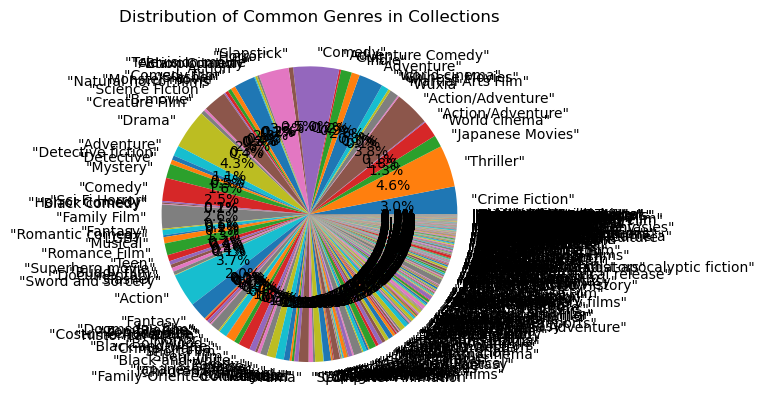

In [14]:
genre_counts = Counter()

for genres in collections['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip() for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','') # works
print(genre_counts_df.sort_values(by='counts', ascending=False))


# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(genre_counts_df['counts'], labels=genre_counts_df['genre'], autopct='%1.1f%%')
plt.title('Distribution of Common Genres in Collections')

                                          genre  counts
10                                   "Thriller"     176
11                                     "Comedy"     166
3                                       "Drama"     165
20                           "Action/Adventure"     152
15                                     "Horror"     134
..                                          ...     ...
60   "Apocalyptic and post-apocalyptic fiction"       1
147                            "Costume Horror"       1
145                                  "Dystopia"       1
144                             "Costume drama"       1
216                               "Silent film"       1

[217 rows x 2 columns]


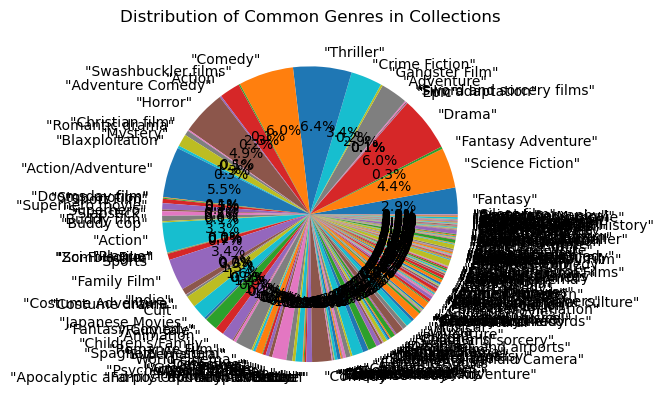

In [15]:
###################################################  TESTING  ########################################################

# Group by 'collection_id' and find common genres in each collection
common_genres_list = []
common_genre_counts = Counter()

for collection_id, group in collections.groupby('collection_id'):
    # Filter out null values and split the genres by comma
    genre_sets = [set(genre.split(":")[1].strip() for genre in genres.split(",") if ":" in genre) 
                  for genres in group['Movie genres (Freebase ID:name tuples)'] if pd.notnull(genres)]
    
    if genre_sets:
        # Find the intersection of all genre sets in the collection
        common_genres = reduce(set.intersection, genre_sets)
        common_genres_list.append((collection_id, common_genres))
        common_genre_counts.update(common_genres)

# Convert the list of tuples to a DataFrame
common_genres_df = pd.DataFrame.from_dict(common_genre_counts, orient='index', columns=['counts']).reset_index()
common_genres_df.columns = ['genre', 'counts']
common_genres_df['genre']=common_genres_df['genre'].str.replace('}','') # works

print(common_genres_df.sort_values(by='counts', ascending=False))

common_genres_df['common_genres'] = common_genres_df['genre'].apply(lambda x: "Comedy" if "comedy" in x.lower() else x)

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(common_genres_df['counts'], labels=common_genres_df['genre'], autopct='%1.1f%%')
plt.title('Distribution of Common Genres in Collections')
plt.show()

                                            counts
"Thriller"                                     176
"Comedy"                                       166
"Drama"                                        165
"Action/Adventure"                             152
"Horror"                                       134
...                                            ...
"Apocalyptic and post-apocalyptic fiction"       1
"Costume Horror"}                                1
"Dystopia"}                                      1
"Costume drama"}                                 1
"Silent film"}                                   1

[217 rows x 1 columns]


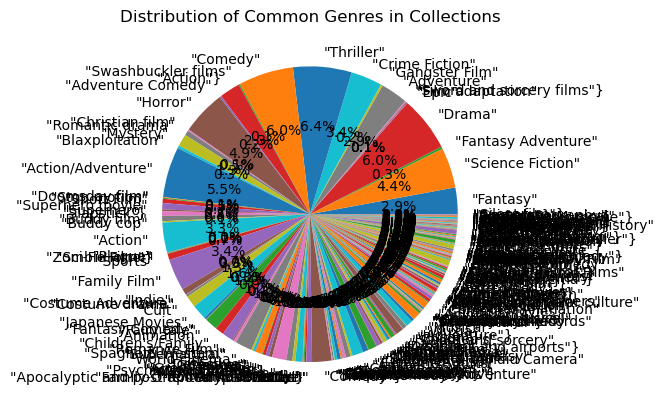

In [16]:
# Group by 'collection_id' and find common genres in each collection
common_genres_list = []

for collection_id, group in collections.groupby('collection_id'):
    # Filter out null values and split the genres by comma
    genre_sets = [set(genre.split(":")[1].strip() for genre in genres.split(",") if ":" in genre) 
                  for genres in group['Movie genres (Freebase ID:name tuples)'] if pd.notnull(genres)]
    
    if genre_sets:
        # Find the intersection of all genre sets in the collection
        common_genres = reduce(set.intersection, genre_sets)
        common_genres_list.append((collection_id, common_genres))

# Convert the list of tuples to a DataFrame
common_genres_df = pd.DataFrame(common_genres_list, columns=['collection_id', 'common_genres'])

# Flatten the list of common genres
flattened_genres = [genre for genres in common_genres_df['common_genres'] for genre in genres]

# Count the occurrences of each genre
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts'])
print(genre_counts_df.sort_values(by='counts', ascending=False))


# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(genre_counts_df['counts'], labels=genre_counts_df.index, autopct='%1.1f%%')
plt.title('Distribution of Common Genres in Collections')
plt.show()

keep only 1 genre in common genres ? the ones that appear most likely \
here I put "other" category for genres appearing less than 1%

In [17]:
# Calculate the total count of all genres
total_common_genres_count = common_genres_df['counts'].sum()

# Determine the threshold count for 1%
threshold_count = total_common_genres_count * 0.01

# Replace genres with counts below the threshold with "other"
common_genres_df['genre'] = common_genres_df.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)

# Group by the new category and sum the counts
common_genres_df = common_genres_df.groupby('genre')['counts'].sum().reset_index()

print(common_genres_df.sort_values(by='counts', ascending=False))

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(common_genres_df['counts'], labels=common_genres_df['genre'], autopct='%1.1f%%')
plt.title('Distribution of Genres in Collections (with "other" category)')
plt.show()

KeyError: 'counts'

have to look more closely at genres name and agree

### Box office

do we take the mean per collection ? Do we look at the mean of 2nd movie in 2-movies sagas ?

(1257, 12)
     collection_id  Movie box office revenue
0             10.0              7.190128e+08
1             84.0              4.959603e+08
2            119.0              9.725023e+08
3            131.0              2.123856e+06
4            151.0              1.026482e+08
..             ...                       ...
662      1235083.0              2.590000e+07
663      1236913.0              4.000000e+06
664      1269386.0              3.647788e+07
665      1286059.0              3.206363e+07
666      1326816.0              1.272977e+06

[667 rows x 2 columns]


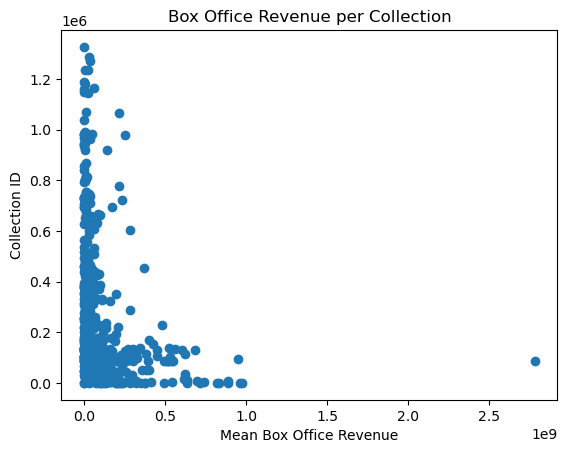

In [310]:
# keeping only the movies with box office revenue
box_office_df = collections.dropna(subset=['Movie box office revenue'])
print(box_office_df.shape)

box_office = box_office_df.groupby(by='collection_id')['Movie box office revenue']
#print(type(box_office))

#print(box_office.describe())

mean_per_collection = box_office.mean()
#print(mean_per_collection)

box_office.describe()

box_office_df = mean_per_collection.reset_index()
print(box_office_df)
plt.plot(box_office_df['Movie box office revenue'], box_office_df['collection_id'], 'o')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Box Office Revenue per Collection')
plt.xlabel('Mean Box Office Revenue')
plt.ylabel('Collection ID')
#plt.xticks(sorted(set(counts)))  
plt.show()

In [18]:
box_office_df = collections.dropna(subset=['Movie box office revenue'])
box_office_df = box_office_df.drop(columns=['Wikipedia movie ID', 'Movie release date', 'Movie runtime', 'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)', 'vote_count', 'vote_average', 'genres', 'run_time', 'tmdb_origin_country', 'tmdb_original_language'])
#print(box_office_df['collection_id'].value_counts())
## we don't have the box office revenue for all the movies in the collection

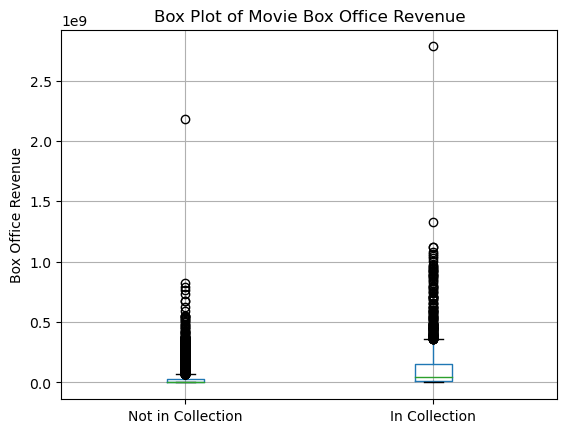

In [19]:
#all box office of movie that are not in collection
data_no_coll = new_data.copy()
data_no_coll = new_data.copy()[data_no_coll['collection_id'].isna()]
movie_box = data_no_coll.dropna(subset=['Movie box office revenue'])
#movie_box['Movie box office revenue'].describe()

# Combine the data into a single DataFrame for plotting
all_box= pd.DataFrame({
    'Not in Collection': movie_box['Movie box office revenue'],
    'In Collection': box_office_df['Movie box office revenue']
})

# Plot the box plot
all_box.boxplot()
plt.title('Box Plot of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

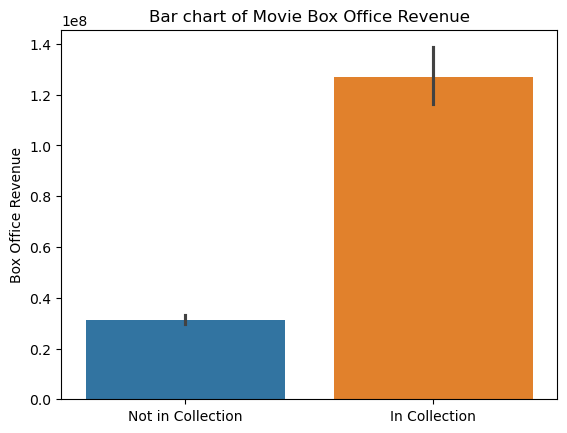

In [20]:
# Plot bar 
import seaborn as sns
ax = sns.barplot(all_box)
plt.title('Bar chart of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

There is a huge difference of box office revenue if the movie is in a collection 

Analysis on Star Wars 

collection_id
645.0       22
9735.0      11
1241.0       8
656.0        7
9338.0       7
            ..
180854.0     2
105625.0     2
9818.0       2
104847.0     2
228887.0     2
Name: count, Length: 344, dtype: int64


/var/folders/7c/8w5xhfsd2xlf5bzs6735qgm40000gn/T/ipykernel_48494/1480667852.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_office['budget'] = box_office['budget'].apply(scientific_notation)


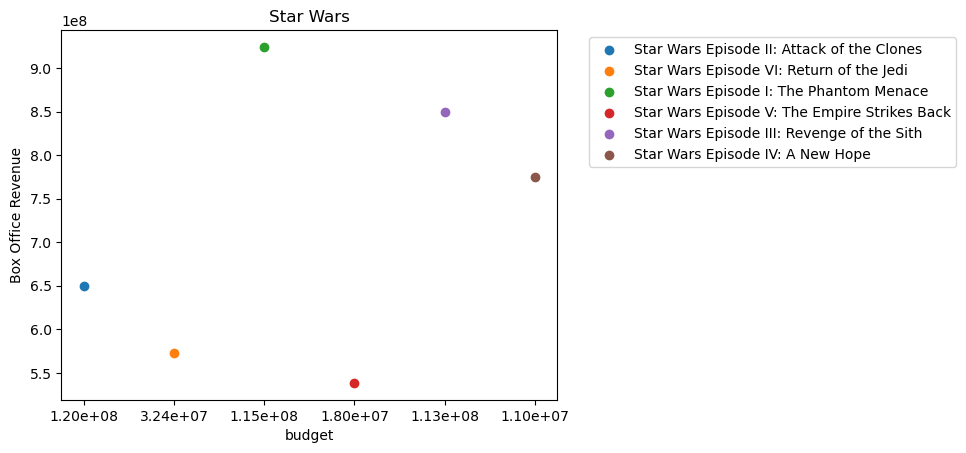

In [22]:
#DATA to use if we want to compare box office in a collection 

box_count = box_office_df['collection_id'].value_counts()
valid_box_id = box_count[box_count > 1].index
box_office = box_office_df[box_office_df['collection_id'].isin(valid_box_id)]
print(box_office['collection_id'].value_counts())
#Now we only have collection box office info on colelction with more than 1 movie

# Define a formatting function to convert values to scientific notation
def scientific_notation(x):
    return "{:.2e}".format(x)

box_office['budget'] = box_office['budget'].apply(scientific_notation)

filtered_df = box_office[box_office['collection_id'] == 10]

for index, row in filtered_df.iterrows():
    plt.scatter(row['budget'], row['revenue'], label=row['Movie name'])

#plt.scatter(box_office[box_office['collection_id'] == 10]['budget'], box_office[box_office['collection_id'] == 10]['revenue'])
plt.ylabel('Box Office Revenue')
plt.xlabel('budget')
plt.legend()
plt.title('Star Wars')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')